In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Bayesian parameter estimation of cosmological models using MCMC
## Jaume Celma Mateu

In this project, I applied Bayesian statistical methods to cosmological data to estimate fundamental parameters of the universe, including the Hubble constant ($H_0$) and the matter density parameter ($\Omega_m$).

A cosmological experiment provides a measurement of the expansion history of the Universe,
H(z), obtained from the ages of passively-evolving galaxies in galaxy clusters at various redshifts,
z. These measurements of H(z) can be used to constrain the Hubble parameter $H_0$, quantifying
the local expansion rate, and the matter density in the Universe, Ωm, using the following mod

$$ H(z) = H_0 \sqrt{\Omega_m (1 + z)^3 + (1 - \Omega_m)} $$

The measurements can be read from the data file as:
 - z (redshift)
 - h (H(z))
 - herr(H(z) mesurament error)

In [3]:
z, h, herr = np.loadtxt('Hz_BC03_all.dat',unpack=True)

If D denotes the data provided by the measurements of H(z), and H0, Ωm are the parameters of
the model of Equation (1), we want to use Bayesian parameter inference to compute the posterior
probability

$$ p(H_0, \Omega_m \mid D) \propto p(D \mid H_0, \Omega_m) \, p(H_0, \Omega_m) $$

using Monte Carlo Markov Chains (with the Metropolis implementation). For the likelihood,
$p(D \mid H_0, \Omega_m)$), you can assume a Gaussian likelihood, given the measurement uncertainties that are
provided in the data file (the column named herr above). In the case of this example, the data is
composed of Hi measurements at different zi
, with uncertainties σi
. The Gaussian likelihood will then be comput


$$
p(D \mid H_0, \Omega_m) 
= \prod_i p(D_i \mid H_0, \Omega_m) 
= \prod_i \exp\left( -\frac{(H_i - H(z_i; H_0, \Omega_m))^2}{\sigma_i^2} \right)
$$
where H(zi
, H0, Ωm) is the evaluation of the model at zi with parameters H0, Ωm. This can also
be wrsitten a

$$
p(D \mid H_0, \Omega_m) = \exp\left(-\frac{\chi^2}{2}\right), 
\quad \text{with} \quad 
\chi^2 = \sum_i \frac{(H_i - H(z_i; H_0, \Omega_m))^2}{\sigma_i^2}
$$

The analysis starts by plotting the H(z) measurements with their error bars, along with model predictions for a few different parameter combinations. This includes ones that match the data well and ones that differ quite a bit, to give an idea about the range studied.

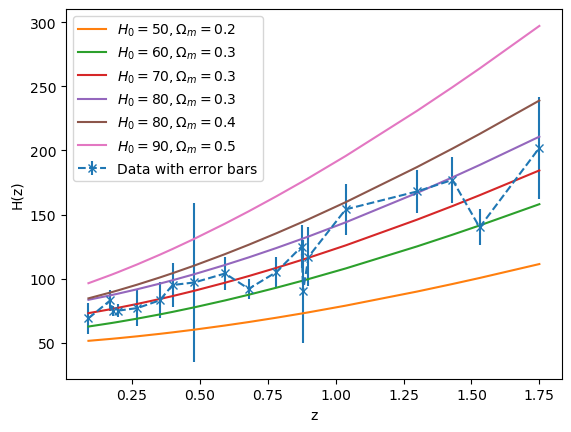

In [5]:
# Defining the cosmological model function ,h_0 omega_m are the parameters of this model.
def model(z,h_0,omega_m):
    return h_0*np.sqrt((omega_m*((1+z)**3))+(1-omega_m))

# Plot the data
plt.errorbar(z,h,yerr=herr,fmt='x--', label='Data with error bars')

# Plot of the cosmological model for some parameter combinations
h_0t=[50,60,70,80,80,90]  # Propose some values of h_0
omega_mt=[0.2,0.3,0.3,0.3,0.4,0.5] # propose some values of omega_m
for i in range(6): # We run 6 plots
    h1=model(z,h_0t[i],omega_mt[i])
    plt.plot(z,h1,label=f'$H_0={h_0t[i]}, \\Omega_m={omega_mt[i]}$')  # Plot z, h
    plt.ylabel('H(z)')
    plt.xlabel('z')
   
plt.legend()
plt.show()  

In this step, I created Python functions to work with the cosmology model and explore parameter space.

#### 1. Model Function
A function that predicts the Hubble parameter `H(z)` for given redshift values, based on the key parameters:

- $ H_0 $ — Hubble constant  
- $\Omega_m$ — Matter density parameter  

#### 2. Posterior Function
Combines the likelihood (how well the model fits the data) with the prior (assumptions about reasonable parameter ranges).

- For the prior, I used a uniform distribution:  
  - $ H_0 $ between 50 and 100  
  - $\Omega_m$ between 0 and 1  

#### 3. Proposal Function
Generates new candidate values for $ H_0 $ and $\Omega_m$ by taking small random steps.  
This helps methods like MCMC efficiently explore the parameter space.

#### 4: MCMC Chain

Using the posterior and proposal functions, I ran a Markov Chain Monte Carlo (MCMC) simulation to explore the parameter space.  

The chain records the sequence of sampled $ H_0 $,$\Omega_m$  values, providing a distribution of plausible parameter combinations.  
This allows us to visualize the posterior distributions and see which parameter values best match the data.


In [6]:
# Uniform prior function. Parameters h_0 and omega_m constraied between [50,100] and [0,1] respectively.
# Is the product of two independent uniform distributions. Out of bounds return 0 value .
def prior(h_0,omega_m):
    if 50 <= h_0 <= 100 and 0 <= omega_m <= 1:
        p_h_0=1/(100-50)  # Uniform h_0 distribution
        p_omega_m=1 # Uniform omega_m distribution
        return p_h_0*p_omega_m
    else :
        return 0  # Imput value outside of our selected range.

# Likelihood function 
def likelihood(h,herr,h_0,omega_m):
    arg=(((h-model(z,h_0,omega_m))**2)/(2*(herr)**2))
    return np.exp(-np.sum(arg))  #Using the formula from the statement

# Posterior as the product of likelihood and prior. We dont need the normalization factor to compute posterior correctly here.
def posterior(h_0,omega_m):
    return likelihood(h,herr,h_0,omega_m)*prior(h_0,omega_m)

# We use a gaussian proposal with mean the input value of both parameters and d evition. Deviation values are selected by trial and error. Best ones I could find.
def proposal(h_0, omega_m):
    n = np.random.normal(h_0, 4)  # Propose h_0 with normal distribution and deviation 4
    m = np.random.normal(omega_m, 0.05)# Propose h_0 with normal distribution and deviation 4
    return n, m

# Chain
def chain(steps,h_0_ini,omega_m_ini):  # Input are initial values of h_0 and omega_m
    chain = np.zeros((steps, 3))   # Inicialize the chain with the form we want
    counts=0   # Counts how many values are accepted
    p=posterior(h_0_ini,omega_m_ini)  # Posterior at initial values to start the loop
    chain[0]=h_0_ini,omega_m_ini,p
    for i in range(steps-1):   # Write the chain
    
        h_0_prop,omega_m_prop=proposal(chain[i,0], chain[i,1]) # Proposal values
        prop=posterior(h_0_prop,omega_m_prop) # Posterior at proposal values
        ratio=prop/chain[i,2] # ratio 
        if ratio>=1: # Accept greater than 1
            chain[i+1]=h_0_prop,omega_m_prop,prop
            counts=counts+1
            
        elif ratio> np.random.random(): # Accept greater than a random number(0,1)
            
            chain[i+1]=h_0_prop,omega_m_prop,prop
            counts=counts+1
            
        else: # reject and run again
            chain[i+1]=chain[i]
    return chain,counts # return the chain and how many values have been accepted




Using the previously defined functions, I ran four MCMC chains, each starting from a different location in the parameter space.  

By plotting the chains, we can check for convergence and identify the burn-in regions that should be discarded before analyzing the results.  
This approach ensures that our posterior distributions are robust and not biased by the starting points.

<Figure size 1000x600 with 0 Axes>

D:\anaconaki\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


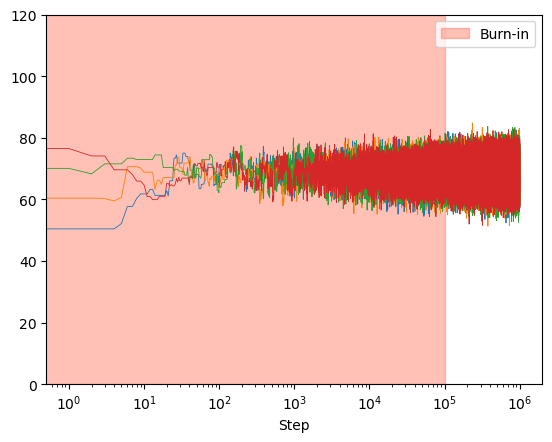

<Figure size 1000x600 with 0 Axes>

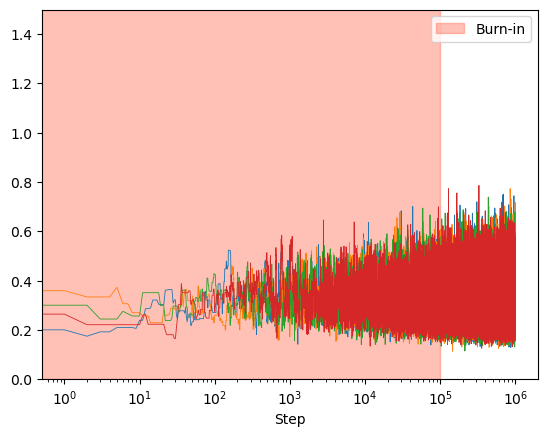

In [7]:

NB=100000 # Burn-in cut region
steps=1000000  # Steps for the sampling
h_0t=[50,60,70,80,80]  #  some initial values of h_0
omega_mt=[0.2,0.3,0.3,0.3,0.4] #  some initial values of omega_m
eff1=[] # Lists to save efficiency values
eff2=[]

plt.figure(figsize=(10,6))
plt.figure()  # Plot figure for values of h_0

for i in range(4): # We run 5 plots
    chain1,counts=chain(steps,h_0t[i],omega_mt[i])
    eff1.append(counts/steps) # efficiency
    plt.plot(chain1[:, 0],lw=0.6)  # Plot z, h
    plt.xlabel('Step')
    plt.xscale('log')  # setting log scale in x 
    plt.ylim([0, 120])
plt.axvspan(0,NB,color='tomato',alpha=0.4, label='Burn-in') # Burn in 
plt.legend()

plt.figure(figsize=(10,6))
plt.figure() # Plot figure for values of omega_m

for i in range(4): # We run 5 plots
    chain2,counts=chain(steps,h_0t[i],omega_mt[i])
    eff2.append(counts/steps) # efficiency
    plt.plot(chain2[:, 1],lw=0.6)  # Plot z, h
    plt.xlabel('Step')
    plt.xscale('log') # setting log scale in x 
    plt.ylim([0, 1.5])

plt.axvspan(0,NB,color='tomato',alpha=0.4, label='Burn-in')
plt.legend()
plt.show()  



Since we are running a lot of steps we choose a burn-in of $10^5$ for our analysis. The decision was based by inspection of the plots, where the parameters values seems to stabilize and show a consistent sampling behaviour of the posterior.

In [8]:
# From eff values computed previously
print(f'Efficiency , {eff1,eff2}')


Efficiency , ([0.360278, 0.360887, 0.360266, 0.360592], [0.360335, 0.360438, 0.359931, 0.360063])


To discuss efficiency and covergence we run 10 chains with differents initial conditions. For this type of problems, an efficiency about 0.25 and 0.40 is consider correct in order to find the posterior distribution.  Since our effieincies obtained are about to $\sim$ 0.36 we consider it as a good  indication of proper sampling behavior.

To discuss convergence we look at the plots of the last part and we can observe that both parameters show a stable behaviour after burn phase. The posteriors distributions overlap, confirming pretty much a consistent sampling from the target distribution.


Now using the samples generated from the chains, we make a 2D density plot of H0, Ωm, and also  1D plots
of each parameter . 

<Figure size 1000x600 with 0 Axes>

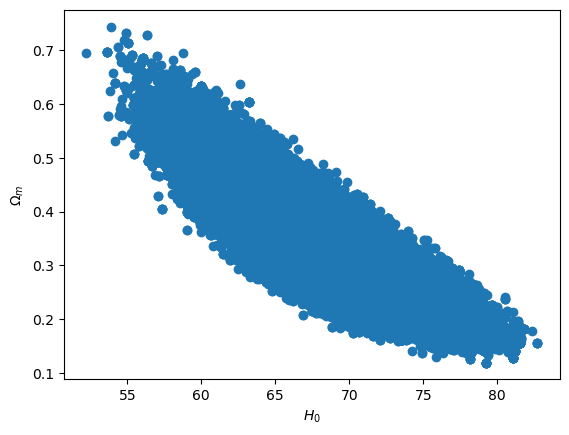

<Figure size 1000x600 with 0 Axes>

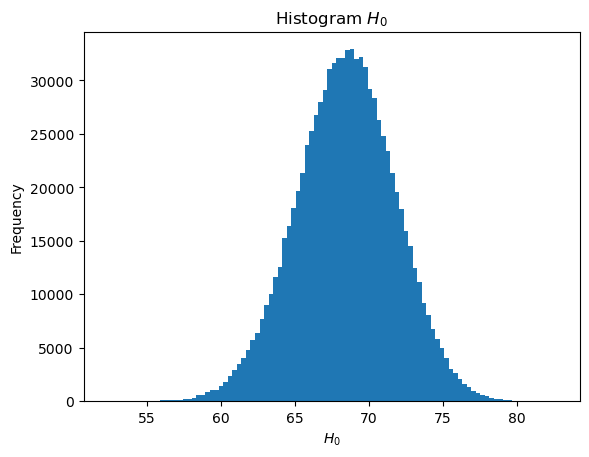

<Figure size 1000x600 with 0 Axes>

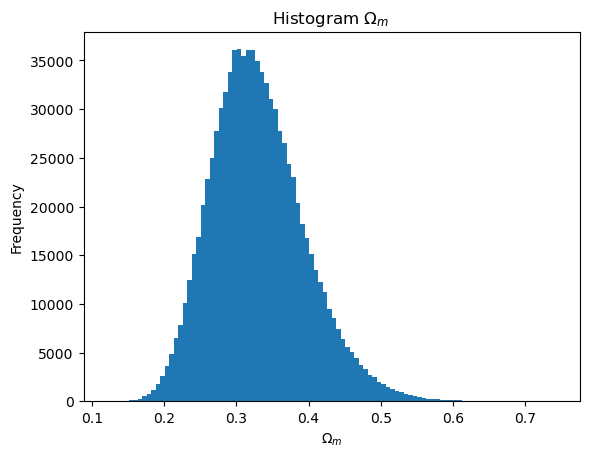

In [9]:
# Since all converge to the same posterior we select random initial values to proceed
NB=100000 # Burning region
steps=1000000 
h_0_i=60 # Initial values of parameters to plug in the chain
omega_m_i=0.2
chai1,_=chain(steps,h_0_i,omega_m_i) 

chai = chai1[NB:] # Remove the burning region
h_0_f, omega_m_f = chai[:,0], chai[:,1] # Save both parameter without the burning region

# Doing the scatter and histograms wihout the burning region. 
plt.figure(figsize=(10,6))
plt.figure()

plt.scatter(h_0_f, omega_m_f) # Scatter plot of one parameter in front of the other.
plt.xlabel(f'$H_0$')
plt.ylabel(f'$ \\Omega_m$')

plt.figure(figsize=(10,6))
plt.figure()
plt.hist(h_0_f,bins=100) # Histogram of h_0 values in the posterior distribution .
plt.xlabel(f'$H_0$')
plt.ylabel('Frequency')
plt.title('Histogram $H_0$ ')

plt.figure(figsize=(10,6))
plt.figure()
plt.hist(omega_m_f,bins=100) # Histogram of omega_m values in the posterior distribution .
plt.xlabel(f'$ \\Omega_m$')
plt.ylabel('Frequency')
plt.title('Histogram $ \\Omega_m$ ')

plt.show()


The histograms look roughly Gaussian, a good sign that the chains are working as intended.





Right now, the focus is on finding reliable confidence intervals around the mode of each parameter’s distribution. Assuming gaussianity and using $\sigma$ alone may be misleading, since the distributions might not be symmetric or free of skewness. Instead, the confidence intervals are derived directly from the sample histograms. 


In [10]:
# 
level=0.68 # 68% confidence interval
def confidenceint(data): # Program a function to compute the confidence interval coming from data
    hist, bin = np.histogram(data, bins=100, density=False) # Make an hisogram with data from parameters without burning region. Bin is the bin lmits
    bin_c = (1/2)*(bin[1:] + bin[:-1]) # Center of each bin
    index=np.argmax(hist) # index of the bin  with maximum value
    mode=bin_c[index] # Maximum value . Mode of the histogram
    sort = np.sort(data) # Sort the values lower to greater
    
    total = len(data)
    inside= int(level * total) #product of the level of confidence and total samples. Index has to be an integer
    
    outside = total - inside # Samples outside our level of confidence
    lower_s = outside / 2  # Fraction of samples outside level of confidence in lower side
    lower_i = int(lower_s) # Index of first value inside of confidence interval
    upper_i = lower_i + inside  # Add this last value to all the samples from the entire interval to find the upper side index.
    
    lower_value = sort[lower_i] # Find the value of the parameter that corresponds to the upper and lower index."
    upper_value = sort[upper_i]
    return lower_value,upper_value # Confidence interval
    
# Confidence intervals at 68 % for h_0 and omega_m:
confid_h_0=confidenceint(h_0_f)
confid_omega_m=confidenceint(omega_m_f)
print(f"Confidance interval of H_0 is {confid_h_0}")
print(f"Confidance interval of omega_m_f is {confid_omega_m}")

Confidance interval of H_0 is (np.float64(65.10475960556109), np.float64(71.75169940818932))
Confidance interval of omega_m_f is (np.float64(0.267321944290662), np.float64(0.3933255793128248))



We repeat the first plot, but now the parameter combinations are taken from the posterior instead of random values.

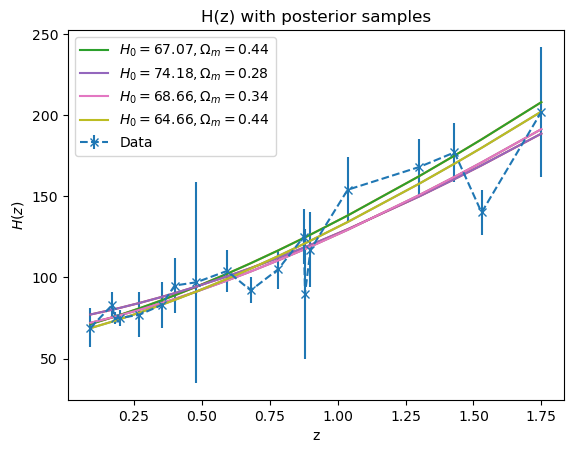

In [11]:
plt.errorbar(z, h, yerr=herr, fmt='x--', label='Data') # Plot again the data 
index= np.random.choice(len(h_0_f), size=4, replace=False) # We choose 4 random pair of values inside our posterior without repetition

for i in index:
    h_0, omega_m = h_0_f[i], omega_m_f[i]
    p=model(z, h_0, omega_m)  # Put the parameters in the cosmological model
   
    plt.plot(z, p, alpha=0.9)
    plt.plot(z,p,label=f'$H_0={h_0_f[i]:.2f}, \\Omega_m={omega_m_f[i]:.2f}$')  # Plot z, h

plt.xlabel('z')
plt.ylabel('$H(z)$')
plt.title('H(z) with posterior samples')
plt.legend()
plt.show()

This time, the analysis is repeated using a different prior. So far, a uniform prior has been used, but now a Gaussian prior on $\Omega_m = 0.315 \pm 0.007$ will be applied. This provides a clear illustration of how Bayesian statistics works and how prior information can be incorporated into the analysis. The prior on  $ H_0 $ remains the same.

In [12]:
# New prior
omega_m_mu=0.315
sigma=0.007
def prior(h_0,omega_m):
    if 50 <= h_0 <= 100 and 0 <= omega_m <= 1:
        p_h_0=1/(100-50)  # Uniform h_0 distribution
        p_omega_m= np.exp(-0.5 * ((omega_m -omega_m_mu ) / sigma)**2) # We change the prior on omega_m
        return p_h_0*p_omega_m
    else :
        return 0  # Imput value outside of our selected range.



<Figure size 1000x600 with 0 Axes>

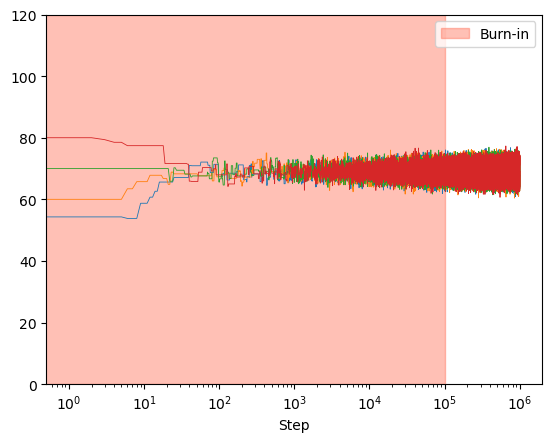

<Figure size 1000x600 with 0 Axes>

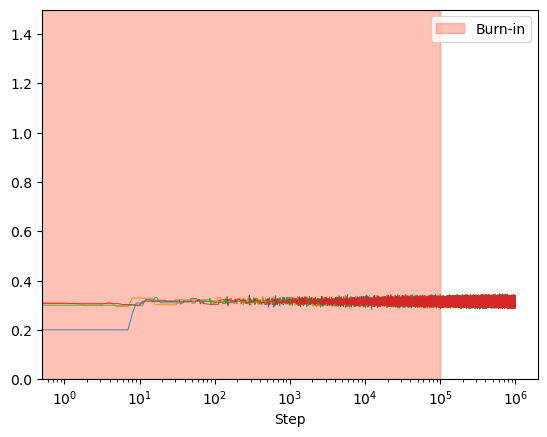

In [13]:
# We run again the chains with this new prior
NB=100000 # Burn-in cut region
steps=1000000  # Steps for the sampling
h_0t=[50,60,70,80,80]  #  some initial values of h_0
omega_mt=[0.2,0.3,0.3,0.3,0.4] #  some initial values of omega_m
eff1=[] # Lists to save efficiency values
eff2=[]

plt.figure(figsize=(10,6))
plt.figure()  # Plot figure for values of h_0

for i in range(4): # We run 4 plots
    chain1,counts=chain(steps,h_0t[i],omega_mt[i])
    eff1.append(counts/steps) # efficiency
    plt.plot(chain1[:, 0],lw=0.6)  # Plot z, h
    plt.xlabel('Step')
    plt.xscale('log')  # setting log scale in x 
    plt.ylim([0, 120])
plt.axvspan(0,NB,color='tomato',alpha=0.4, label='Burn-in') # Burn in 
plt.legend()


plt.figure(figsize=(10,6))
plt.figure() # Plot figure for values of omega_m

for i in range(4): # We run 4 plots
    chain2,counts=chain(steps,h_0t[i],omega_mt[i])
    eff2.append(counts/steps) # efficiency
    plt.plot(chain2[:, 1],lw=0.6)  # Plot z, h
    plt.xlabel('Step')
    plt.xscale('log') # setting log scale in x 
    plt.ylim([0, 1.5])

plt.axvspan(0,NB,color='tomato',alpha=0.4, label='Burn-in')
plt.legend()
plt.show()  


<Figure size 1000x600 with 0 Axes>

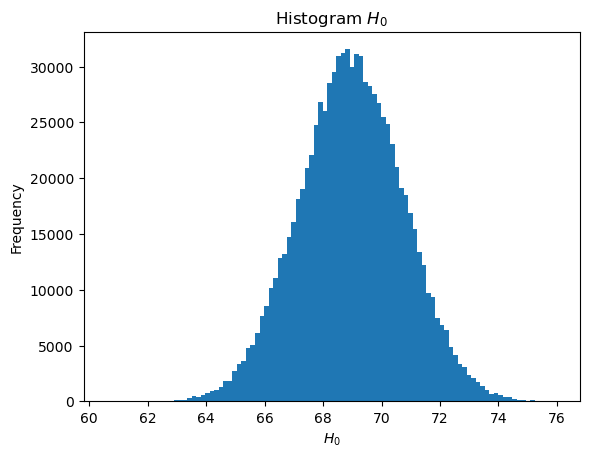

<Figure size 1000x600 with 0 Axes>

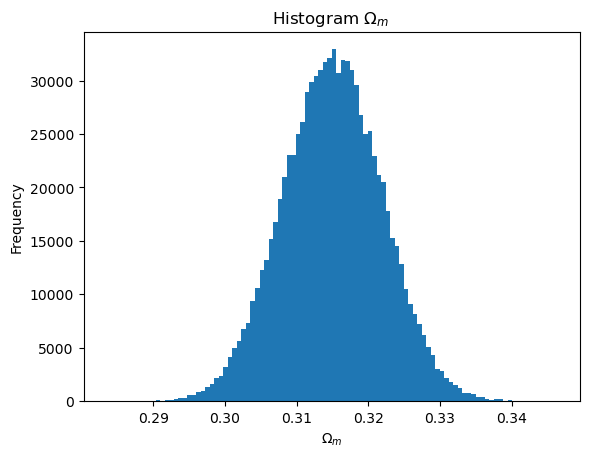

In [19]:
# Run again with new prior
NB=100000 # Burning region
steps=1000000 
h_0_i=60 # Initial values of parameters to plug in the chain
omega_m_i=0.2
chai1,_=chain(steps,h_0_i,omega_m_i) 

chai = chai1[NB:] # Remove the burning region
h_0_f, omega_m_f = chai[:,0], chai[:,1] # Save both parameter without the burning region


plt.figure(figsize=(10,6))
plt.figure()
plt.hist(h_0_f,bins=100) # Histogram of h_0 values in the posterior distribution .
plt.xlabel(f'$H_0$')
plt.ylabel('Frequency')
plt.title('Histogram $H_0$ ')

plt.figure(figsize=(10,6))
plt.figure()
plt.hist(omega_m_f,bins=100) # Histogram of omega_m values in the posterior distribution .
plt.xlabel(f'$ \\Omega_m$')
plt.ylabel('Frequency')
plt.title('Histogram $ \\Omega_m$ ')

plt.show()

In [17]:
print(f'Efficiency , {eff1,eff2}')

Efficiency , ([0.094817, 0.095193, 0.095051, 0.095381], [0.095211, 0.094038, 0.094662, 0.094763])


In [20]:
confid_h_0_g=confidenceint(h_0_f)
confid_omega_m_g=confidenceint(omega_m_f)
print(f"Confidance interval of H_0 is {confid_h_0_g}")
print(f"Confidance interval of omega_m_f is {confid_omega_m_g}")

Confidance interval of H_0 is (np.float64(67.17810220609854), np.float64(70.75860848931535))
Confidance interval of omega_m_f is (np.float64(0.308063203710907), np.float64(0.32192140251281437))


The confidence intervals are narrower with the Gaussian prior on $\Omega_m$ compared to the uniform prior. This is expected because the Gaussian prior introduces additional constraints on $\Omega_m$. The $H_0$ confidence interval is also affected since both variables are related, they are not independent. In cosmological models, $H_0$ and $\Omega_m$ are strongly correlated, so constraining $\Omega$ results in constraining $H_0$ as well. A uniform prior on both parameters allows for a wide range of combinations of $H_0$ and $\Omega_m$, leading to a larger confidence interval for $H_0$.

The confidence interval for $\Omega_m$ is narrower because of the imposed prior. The posterior distribution is the product of the likelihood and the prior. With a uniform prior, the value of the parameter is primarily constrained by the data, as $\Omega_m$ can vary freely within its range. However, if we impose a strict condition on the prior for $\Omega_m$, this significantly reduces the uncertainty on $ \Omega$ in the posterior, resulting in a much narrower confidence interval.